<a href="https://colab.research.google.com/github/Mateo289/Teoria_senales/blob/main/17_Diciembre_cuaderno1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

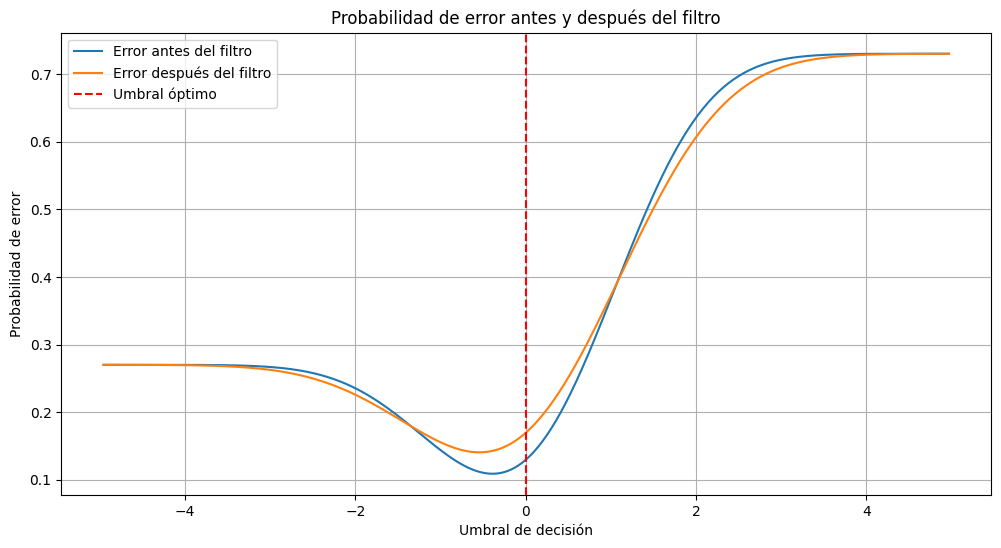

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

# Parámetros iniciales
np.random.seed(42)
a1 = 1  # símbolo 1
a0 = -1  # símbolo 0
p_0 = 0.27  # probabilidad de a0
p_1 = 1 - p_0  # probabilidad de a1
Nsymbols = 1000
Nsample = 100
sigma = np.sqrt(np.pi / 4)  # desviación estándar del ruido

# Generación de datos
data = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
data = np.repeat(data, Nsample)  # extender los símbolos
noise = np.random.normal(0, sigma, len(data))
y = data + noise  # señal con ruido

# Filtro RC (pasa bajos)
def rc_low_pass_filter(signal, R=3000, C=0.0003, dt=1):
    tau = R * C
    alpha = dt / (tau + dt)
    filtered_signal = np.zeros_like(signal)
    for i in range(1, len(signal)):
        filtered_signal[i] = alpha * signal[i] + (1 - alpha) * filtered_signal[i - 1]
    return filtered_signal

y_filtered = rc_low_pass_filter(y)

# Función para calcular la probabilidad de error
def probability_error(y_range, mean_0, mean_1, std, p_0, p_1):
    errors = []
    for threshold in y_range:
        # P(a0 recibido como a1)
        p_a0_as_a1, _ = quad(lambda x: norm.pdf(x, mean_0, std), threshold, np.inf)
        # P(a1 recibido como a0)
        p_a1_as_a0, _ = quad(lambda x: norm.pdf(x, mean_1, std), -np.inf, threshold)
        total_error = p_0 * p_a0_as_a1 + p_1 * p_a1_as_a0
        errors.append(total_error)
    return np.array(errors)

# Rango de decisión
y_range = np.linspace(min(y), max(y), 500)

# Probabilidad de error antes del filtro
error_before = probability_error(y_range, a0, a1, sigma, p_0, p_1)

# Probabilidad de error después del filtro
sigma_filtered = np.std(y_filtered)
error_after = probability_error(y_range, a0, a1, sigma_filtered, p_0, p_1)

# Gráficos
plt.figure(figsize=(12, 6))
plt.plot(y_range, error_before, label="Error antes del filtro")
plt.plot(y_range, error_after, label="Error después del filtro")
plt.axvline((a0 + a1) / 2, color="red", linestyle="--", label="Umbral óptimo")
plt.xlabel("Umbral de decisión")
plt.ylabel("Probabilidad de error")
plt.title("Probabilidad de error antes y después del filtro")
plt.legend()
plt.grid()
plt.show()


Caso σ² = π/4:
Umbral óptimo teórico (original): -0.39158, Error mínimo teórico (aprox) ~ 0.27000
Umbral óptimo numérico (original): 6.14661, Error = 0.27000
Umbral óptimo teórico (filtrado): -0.13430, Error mínimo teórico (aprox) ~ 0.27000
Umbral óptimo numérico (filtrado): 4.30778, Error = 0.27000
Caso σ² = π/8:
Umbral óptimo teórico (original): -0.19440, Error mínimo teórico (aprox) ~ 0.27000
Umbral óptimo numérico (original): 4.83674, Error = 0.27000
Umbral óptimo teórico (filtrado): -0.06664, Error mínimo teórico (aprox) ~ 0.27000
Umbral óptimo numérico (filtrado): 3.61418, Error = 0.27000


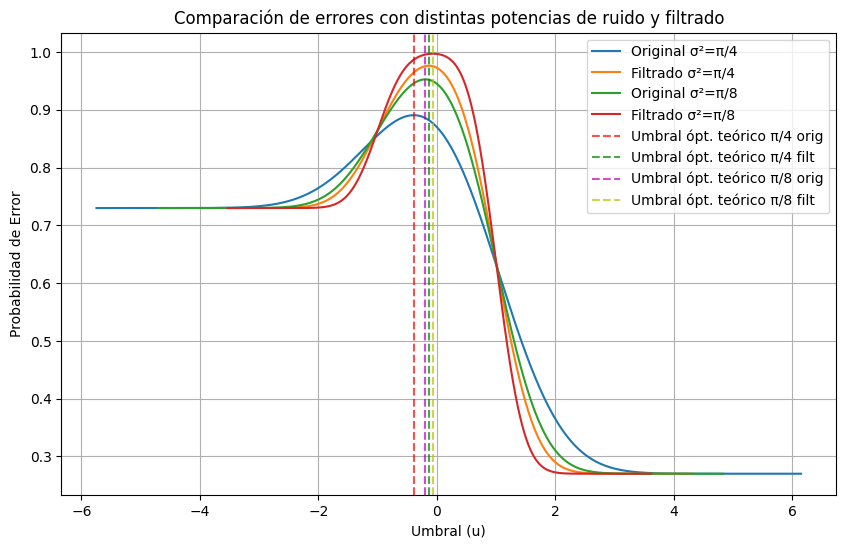

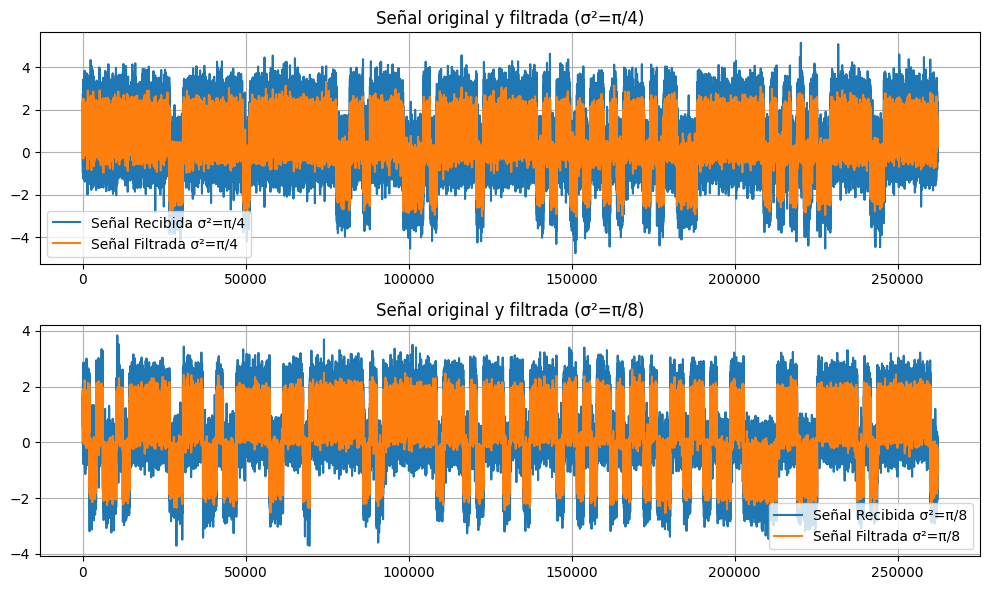

In [ ]:
import numpy as np
import scipy.stats
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.signal import lti

# Parámetros generales
a1 = 1
a0 = -1
p_0 = 0.27
p_1 = 1 - p_0
gamma = p_0/p_1  # razón de priors

Nsymbols = 128
Nsample = 2048
N = Nsymbols*Nsample
Δt = 1/Nsample
time = np.arange(N)

# Función auxiliar: Generar y filtrar señal
def generate_and_filter(σ2):
    # Generar símbolos
    data = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
    message = np.concatenate([[a]*Nsample for a in data])

    # Ruido
    noise = np.random.normal(0, np.sqrt(σ2), N)
    y = message + noise

    # Filtrado RC (pasa-bajos)
    R = 3000; C = 0.0003; τ = R*C
    num = [1]
    den = [τ, 1]
    lti_system = lti(num, den)
    _, y_fil, _ = lti_system.output(y, time)

    return message, y, y_fil, data

def pdf_a0(x, mean0, var):
    return scipy.stats.norm.pdf(x, mean0, np.sqrt(var))

def pdf_a1(x, mean1, var):
    return scipy.stats.norm.pdf(x, mean1, np.sqrt(var))

def compute_error_curve(y, message, a0, a1, p_0, p_1):
    # Estimación de varianza del ruido con respecto a a0
    indices_a0 = (message == a0)
    # Suponemos ruido con misma varianza en ambos símbolos
    var_est = np.var(y[indices_a0] - a0)
    mean0 = a0
    mean1 = a1

    # Crear rango de umbrales
    u_min = y.min()-1.0
    u_max = y.max()+1.0
    gamma_range = np.linspace(u_min, u_max, 1000)

    error_list = []
    for u in gamma_range:
        # P(decidir a1|a0): integrar pdf a0 de -inf a u
        res0, _ = quad(lambda x: pdf_a0(x, mean0, var_est), -np.inf, u)
        # P(decidir a0|a1): integrar pdf a1 de u a inf
        res1, _ = quad(lambda x: pdf_a1(x, mean1, var_est), u, np.inf)
        pe = p_0*res0 + p_1*res1
        error_list.append(pe)

    error_array = np.array(error_list)
    return gamma_range, error_array, var_est

def optimal_threshold_equal_variance(mu0, mu1, var, gamma):
    # Fórmula para umbral óptimo en caso varianzas iguales:
    return (mu0+mu1)/2 + (var/(mu1 - mu0))*np.log(gamma)

# Caso 1: σ² = π/4
σ2_1 = np.pi/4
message_1, y_1, y_1_fil, data_1 = generate_and_filter(σ2_1)
γ_1_orig, err_1_orig, var_1_orig = compute_error_curve(y_1, message_1, a0, a1, p_0, p_1)
γ_1_fil, err_1_fil, var_1_fil = compute_error_curve(y_1_fil, message_1, a0, a1, p_0, p_1)

# Caso 2: σ² = π/8
σ2_2 = np.pi/8
message_2, y_2, y_2_fil, data_2 = generate_and_filter(σ2_2)
γ_2_orig, err_2_orig, var_2_orig = compute_error_curve(y_2, message_2, a0, a1, p_0, p_1)
γ_2_fil, err_2_fil, var_2_fil = compute_error_curve(y_2_fil, message_2, a0, a1, p_0, p_1)

# Calcular umbrales óptimos teóricos
y_opt_1_orig = optimal_threshold_equal_variance(a0, a1, var_1_orig, gamma)
y_opt_1_fil = optimal_threshold_equal_variance(a0, a1, var_1_fil, gamma)

y_opt_2_orig = optimal_threshold_equal_variance(a0, a1, var_2_orig, gamma)
y_opt_2_fil = optimal_threshold_equal_variance(a0, a1, var_2_fil, gamma)

# Buscar error mínimo en las curvas empíricas
min_err_1_orig = err_1_orig.min()
u_min_1_orig = γ_1_orig[np.argmin(err_1_orig)]

min_err_1_fil = err_1_fil.min()
u_min_1_fil = γ_1_fil[np.argmin(err_1_fil)]

min_err_2_orig = err_2_orig.min()
u_min_2_orig = γ_2_orig[np.argmin(err_2_orig)]

min_err_2_fil = err_2_fil.min()
u_min_2_fil = γ_2_fil[np.argmin(err_2_fil)]

# Imprimir resultados
print("Caso σ² = π/4:")
print(f"Umbral óptimo teórico (original): {y_opt_1_orig:.5f}, Error mínimo teórico (aprox) ~ {min_err_1_orig:.5f}")
print(f"Umbral óptimo numérico (original): {u_min_1_orig:.5f}, Error = {min_err_1_orig:.5f}")
print(f"Umbral óptimo teórico (filtrado): {y_opt_1_fil:.5f}, Error mínimo teórico (aprox) ~ {min_err_1_fil:.5f}")
print(f"Umbral óptimo numérico (filtrado): {u_min_1_fil:.5f}, Error = {min_err_1_fil:.5f}")

print("Caso σ² = π/8:")
print(f"Umbral óptimo teórico (original): {y_opt_2_orig:.5f}, Error mínimo teórico (aprox) ~ {min_err_2_orig:.5f}")
print(f"Umbral óptimo numérico (original): {u_min_2_orig:.5f}, Error = {min_err_2_orig:.5f}")
print(f"Umbral óptimo teórico (filtrado): {y_opt_2_fil:.5f}, Error mínimo teórico (aprox) ~ {min_err_2_fil:.5f}")
print(f"Umbral óptimo numérico (filtrado): {u_min_2_fil:.5f}, Error = {min_err_2_fil:.5f}")

# Graficar comparación de errores
plt.figure(figsize=(10,6))
plt.plot(γ_1_orig, err_1_orig, label='Original σ²=π/4')
plt.plot(γ_1_fil, err_1_fil, label='Filtrado σ²=π/4')
plt.plot(γ_2_orig, err_2_orig, label='Original σ²=π/8')
plt.plot(γ_2_fil, err_2_fil, label='Filtrado σ²=π/8')

# Marcar umbrales teóricos
plt.axvline(y_opt_1_orig, color='r', linestyle='--', alpha=0.7, label='Umbral ópt. teórico π/4 orig')
plt.axvline(y_opt_1_fil, color='g', linestyle='--', alpha=0.7, label='Umbral ópt. teórico π/4 filt')
plt.axvline(y_opt_2_orig, color='m', linestyle='--', alpha=0.7, label='Umbral ópt. teórico π/8 orig')
plt.axvline(y_opt_2_fil, color='y', linestyle='--', alpha=0.7, label='Umbral ópt. teórico π/8 filt')

plt.xlabel('Umbral (u)')
plt.ylabel('Probabilidad de Error')
plt.title('Comparación de errores con distintas potencias de ruido y filtrado')
plt.grid(True)
plt.legend()
plt.show()

# Graficar la señal original y filtrada para pi/4 y pi/8
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.plot(y_1, label='Señal Recibida σ²=π/4')
plt.plot(y_1_fil, label='Señal Filtrada σ²=π/4')
plt.title('Señal original y filtrada (σ²=π/4)')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(y_2, label='Señal Recibida σ²=π/8')
plt.plot(y_2_fil, label='Señal Filtrada σ²=π/8')
plt.title('Señal original y filtrada (σ²=π/8)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


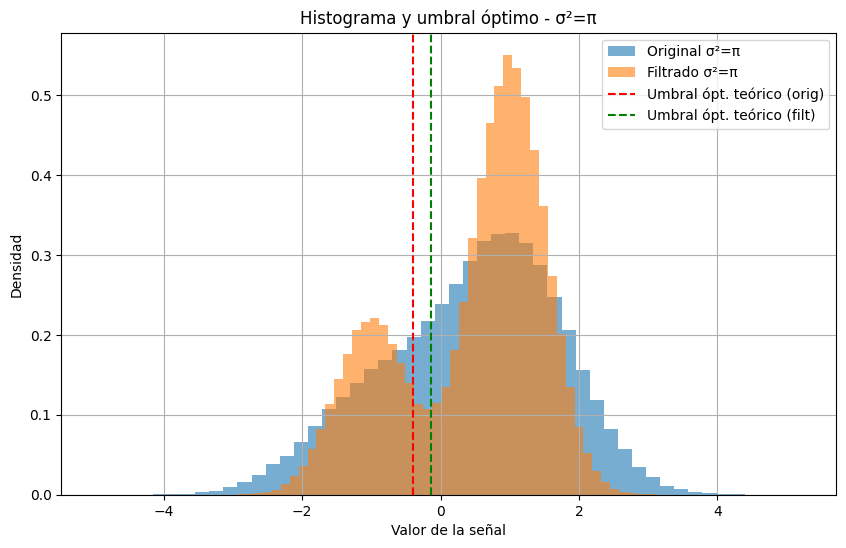

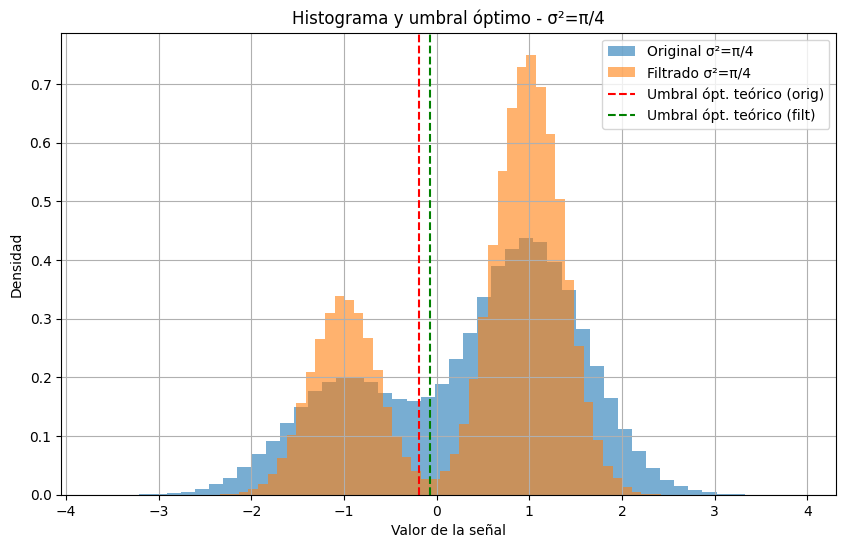

Resultados:
σ²=π -> Umbral óptimo teórico (original): -0.39154
σ²=π -> Umbral óptimo teórico (filtrado): -0.13432
σ²=π/4 -> Umbral óptimo teórico (original): -0.19555
σ²=π/4 -> Umbral óptimo teórico (filtrado): -0.06670


In [3]:
import numpy as np
import scipy.stats
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.signal import lti

# Parámetros generales
a1 = 1
a0 = -1
p_0 = 0.27
p_1 = 1 - p_0
gamma = p_0 / p_1  # razón de priors

Nsymbols = 128
Nsample = 2048
N = Nsymbols * Nsample
Δt = 1 / Nsample
time = np.arange(N)

# Función auxiliar: Generar y filtrar señal
def generate_and_filter(σ2):
    # Generar símbolos
    data = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
    message = np.concatenate([[a] * Nsample for a in data])

    # Ruido
    noise = np.random.normal(0, np.sqrt(σ2), N)
    y = message + noise

    # Filtrado RC (pasa-bajos)
    R = 3000; C = 0.0003; τ = R * C
    num = [1]
    den = [τ, 1]
    lti_system = lti(num, den)
    _, y_fil, _ = lti_system.output(y, time)

    return message, y, y_fil, data

# Función para calcular umbral óptimo
def optimal_threshold_equal_variance(mu0, mu1, var, gamma):
    return (mu0 + mu1) / 2 + (var / (mu1 - mu0)) * np.log(gamma)

# Función para calcular error usando histogramas
def compute_error_histogram(y, message, a0, a1, p_0, p_1, bins=50):
    # Estimación de la varianza
    var_est = np.var(y[message == a0] - a0)

    # Calcular histogramas
    counts, edges = np.histogram(y, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2  # centros de los bins

    # Calcular pdf teórica
    pdf0 = scipy.stats.norm.pdf(centers, a0, np.sqrt(var_est))
    pdf1 = scipy.stats.norm.pdf(centers, a1, np.sqrt(var_est))

    # Probabilidad de error para diferentes umbrales
    error_list = []
    for u in centers:
        # P(decidir a1|a0): integrar de -inf a u
        pe0 = np.trapz(pdf0[centers < u], centers[centers < u])
        # P(decidir a0|a1): integrar de u a inf
        pe1 = np.trapz(pdf1[centers >= u], centers[centers >= u])
        pe = p_0 * pe0 + p_1 * pe1
        error_list.append(pe)

    error_array = np.array(error_list)
    return centers, error_array, var_est

# Caso 1: σ² = π
σ2_1 = np.pi/4
message_1, y_1, y_1_fil, data_1 = generate_and_filter(σ2_1)
γ_1_orig, err_1_orig, var_1_orig = compute_error_histogram(y_1, message_1, a0, a1, p_0, p_1)
γ_1_fil, err_1_fil, var_1_fil = compute_error_histogram(y_1_fil, message_1, a0, a1, p_0, p_1)

# Caso 2: σ² = π/4
σ2_2 = np.pi / 8
message_2, y_2, y_2_fil, data_2 = generate_and_filter(σ2_2)
γ_2_orig, err_2_orig, var_2_orig = compute_error_histogram(y_2, message_2, a0, a1, p_0, p_1)
γ_2_fil, err_2_fil, var_2_fil = compute_error_histogram(y_2_fil, message_2, a0, a1, p_0, p_1)

# Calcular umbrales óptimos
y_opt_1_orig = optimal_threshold_equal_variance(a0, a1, var_1_orig, gamma)
y_opt_1_fil = optimal_threshold_equal_variance(a0, a1, var_1_fil, gamma)

y_opt_2_orig = optimal_threshold_equal_variance(a0, a1, var_2_orig, gamma)
y_opt_2_fil = optimal_threshold_equal_variance(a0, a1, var_2_fil, gamma)

# Graficar histogramas y umbrales para σ² = π
plt.figure(figsize=(10, 6))
plt.hist(y_1, bins=50, density=True, alpha=0.6, label='Original σ²=π')
plt.hist(y_1_fil, bins=50, density=True, alpha=0.6, label='Filtrado σ²=π')
plt.axvline(y_opt_1_orig, color='r', linestyle='--', label='Umbral ópt. teórico (orig)')
plt.axvline(y_opt_1_fil, color='g', linestyle='--', label='Umbral ópt. teórico (filt)')
plt.title('Histograma y umbral óptimo - σ²=π')
plt.xlabel('Valor de la señal')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)

# Graficar histogramas y umbrales para σ² = π/4
plt.figure(figsize=(10, 6))
plt.hist(y_2, bins=50, density=True, alpha=0.6, label='Original σ²=π/4')
plt.hist(y_2_fil, bins=50, density=True, alpha=0.6, label='Filtrado σ²=π/4')
plt.axvline(y_opt_2_orig, color='r', linestyle='--', label='Umbral ópt. teórico (orig)')
plt.axvline(y_opt_2_fil, color='g', linestyle='--', label='Umbral ópt. teórico (filt)')
plt.title('Histograma y umbral óptimo - σ²=π/4')
plt.xlabel('Valor de la señal')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)

plt.show()

# Mostrar resultados en consola
print("Resultados:")
print(f"σ²=π -> Umbral óptimo teórico (original): {y_opt_1_orig:.5f}")
print(f"σ²=π -> Umbral óptimo teórico (filtrado): {y_opt_1_fil:.5f}")
print(f"σ²=π/4 -> Umbral óptimo teórico (original): {y_opt_2_orig:.5f}")
print(f"σ²=π/4 -> Umbral óptimo teórico (filtrado): {y_opt_2_fil:.5f}")
